**Enhancing Financial Inclusion in Africa: A Machine Learning Challenge**

**Objective:**
This competition  build a machine learning model to predict whether individuals in Kenya, Rwanda, Tanzania, and Uganda are likely to have or use a bank account. By analyzing key demographic and socioeconomic factors, the model will help:

*   Identify barriers preventing people from accessing formal banking services.
*   Guide policymakers and organizations in designing better financial products for underserved populations.
*   Measure financial inclusion across these countries.

**Why This Matters:**
Millions of adults in Africa remain **unbanked**—meaning they lack access to savings, credit, and secure transactions.

The model will contribute to:


*   **Economic empowerment** by understanding who is excluded and why.
*   **Data-driven solutions** to expand financial services to marginalized groups (e.g., women, rural communities, low-income individuals).

*   **Progress toward the UN’s Sustainable Development Goals (SDGs)**, particularly **SDG 1 (No Poverty)** and **SDG 8 (Decent Work & Economic Growth)**.

What We Learn:

*   **Real-world ML application:** Predict financial behavior using demographic data.
*   **Feature importance analysis:** Discover which factors (e.g., income, education, mobile access) most influence banking adoption.

*   **Impact-driven data science:** Your work can help shape policies that improve lives.














**Step 1: Understand the Problem & Data**

**Objective:** Predict whether an individual has or uses a bank account (binary classification).

**Key Questions:**

* What factors (e.g., income, education, mobile access) influence financial inclusion?

* How does financial inclusion vary across Kenya, Rwanda, Tanzania, and Uganda?

**Data Exploration:**

Load and inspect the dataset (e.g., using pandas in Python).

**Check for:**

* Missing values (df.isnull().sum()).

* Data types (numeric vs. categorical).

* Class imbalance (ratio of "banked" vs. "unbanked" individuals).

**Step 2: Preprocess the Data**

1. **Handle Missing Values:**

  * Drop rows/columns with excessive missing data.

  * Impute remaining gaps (e.g., mean/median for numeric, mode for categorical).

2. **Encode Categorical Variables:**

  * Use LabelEncoder or OneHotEncoder for features like country, education level, etc.

3. **Feature Engineering:**

  *  Create new features if helpful (e.g., combining "mobile ownership" + "internet access").

4. **Scale Numeric Features:**

  * Standardize (e.g., StandardScaler) for algorithms like SVM or logistic regression.

## Step 1: Import Libraries 🛠️

In [1]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Set the project path
project_path = '/content/drive/My Drive/FinancialInclusion'

# List files in the directory to confirm if files are present
import os
print(os.listdir(project_path))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['StarterNotebook.ipynb', 'first_submission.csv', 'catboost_info', '.ipynb_checkpoints', 'SampleSubmission.csv', 'VariableDefinitions.csv', 'Test.csv', 'Train.csv']


In [2]:
!pip install --upgrade numpy
!pip uninstall -y catboost
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 47.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.19 requires numpy<2,>=1.26.4; python_version < "3.12", but you have numpy 2.2.4 which is incompatible.
thinc 8.2.5 requires numpy<2.0.0,>=1.19.0; python_version >= "3.9", but you have numpy 2.2.4 which is incompatible.
pytensor 2.27.1 requires numpy<2,>=1.17.0, but you have numpy 2.2.4 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numb

In [53]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import catboost
from catboost import CatBoostClassifier, Pool, metrics, cv


**Step 3: Exploratory Data Analysis (EDA)**
 Visualize relationships to guide modeling:

* **Count plots:** Distribution of banked/unbanked by country, gender, etc.

* **Correlation heatmaps:** Identify influential features.

* **Box plots:** Compare income/age distributions between classes.

In [7]:
def wrangle(data_path='./', verbose=True):
    """
    Load and prepare the financial inclusion datasets for Kenya, Rwanda, Tanzania, and Uganda.

    Parameters:
    -----------
    data_path : str (default='./')
        Path to directory containing the datasets
    verbose : bool (default=True)
        Whether to print progress messages

    Returns:
    --------
    tuple : (train, test, vardef) DataFrames
        Cleaned and prepared datasets
    """

    def load_data(filename):
        """Helper function to load individual datasets"""
        try:
            df = pd.read_csv(f"{data_path}/{filename}")
            if verbose:
                print(f"✅ Successfully loaded {filename}")
            return df
        except FileNotFoundError:
            if verbose:
                print(f"❌ File {filename} not found in {data_path}")
            return None

    if verbose:
        print("\n" + "="*50)
        print("🚀 Starting Data Wrangling Process")
        print("="*50 + "\n")

    #  Load all datasets
    train = load_data('Train.csv')
    test = load_data('Test.csv')
    vardef = load_data('VariableDefinitions.csv')
    ss = load_data('SampleSubmission.csv')

    # Check if datasets loaded successfully
    if train is None or test is None or vardef is None:
        raise FileNotFoundError("Required data files not found in specified path")

    if verbose:
        print("\n🔍 Initial Data Overview:")
        print(f"- Training set: {train.shape[0]} rows, {train.shape[1]} columns")
        print(f"- Test set: {test.shape[0]} rows, {test.shape[1]} columns")
        print(f"- Variable definitions: {vardef.shape[0]} features defined\n")
        print(f"- Sample submission: {ss.shape[0]} sample  submission\n")

    #  Create copies to preserve raw data
    train_clean = train.copy()
    test_clean = test.copy()

    #  Convert target variable to binary (if exists)
    if 'bank_account' in train_clean.columns:
        train_clean['bank_account'] = train_clean['bank_account'].map({'Yes': 1, 'No': 0})
        if verbose:
            print("🔄 Converted target variable 'bank_account' to binary (1=Yes, 0=No)")

    #  Handle missing values
    for df in [train_clean, test_clean]:
        # Check for missing values
        if df.isnull().sum().sum() > 0:
            if verbose:
                print(f"\n⚠️ Missing values found in {'train' if 'bank_account' in df.columns else 'test'} set:")
                print(df.isnull().sum()[df.isnull().sum() > 0])

            # Fill numerical missing values with median
            num_cols = df.select_dtypes(include=np.number).columns
            df[num_cols] = df[num_cols].fillna(df[num_cols].median())

            # Fill categorical missing values with mode
            cat_cols = df.select_dtypes(include='object').columns
            for col in cat_cols:
                df[col] = df[col].fillna(df[col].mode()[0])

            if verbose:
                print("✅ Missing values imputed (median for numerical, mode for categorical)")
        else:
            if verbose:
                print(f"\n✅ No missing values in {'train' if 'bank_account' in df.columns else 'test'} set")

    #  Feature engineering
    for df in [train_clean, test_clean]:
        # Create age groups
        df['age_group'] = pd.cut(df['age_of_respondent'],
                                bins=[0, 18, 25, 35, 45, 55, 65, 100],
                                labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+'])

        # Create simplified education levels
        df['education_simplified'] = df['education_level'].replace({
            'No formal education': 'None',
            'Primary education': 'Primary',
            'Secondary education': 'Secondary',
            'Vocational/Specialised training': 'Vocational',
            'Tertiary education': 'Tertiary',
            'Other/Dont know/RTA': 'Other'
        })

        # Create household size categories
        df['household_size_category'] = pd.cut(df['household_size'],
                                             bins=[0, 1, 3, 5, 10, 100],
                                             labels=['Single', 'Small', 'Medium', 'Large', 'Very Large'])

    if verbose:
        print("\n✨ Added new features:")
        print("- age_group: Categorical age ranges")
        print("- education_simplified: Simplified education categories")
        print("- household_size_category: Categorized household sizes\n")

    #  Data type optimization
    for df in [train_clean, test_clean]:
        # Convert specific columns to category type to save memory
        cat_cols = ['country', 'location_type', 'cellphone_access', 'gender_of_respondent',
                   'relationship_with_head', 'marital_status', 'education_level',
                   'job_type', 'age_group', 'education_simplified', 'household_size_category']

        for col in cat_cols:
            if col in df.columns:
                df[col] = df[col].astype('category')

    if verbose:
        # Memory usage before and after optimization
        orig_mem = sum(train.memory_usage(deep=True)) / 1024**2
        new_mem = sum(train_clean.memory_usage(deep=True)) / 1024**2
        print(f"📉 Reduced memory usage from {orig_mem:.2f} MB to {new_mem:.2f} MB ({(1-new_mem/orig_mem)*100:.1f}% reduction)")

        print("\n" + "="*50)
        print("🎉 Data Wrangling Complete!")
        print("="*50 + "\n")

    return train_clean, test_clean, vardef,ss

In [8]:
# Load the data using the wrangle function
train, test, vardef, ss = wrangle(data_path='/content/drive/My Drive/FinancialInclusion')

# Display the first 5 rows of the training set
print("First 5 rows of the training set:")
display(train.head())


🚀 Starting Data Wrangling Process

✅ Successfully loaded Train.csv
✅ Successfully loaded Test.csv
✅ Successfully loaded VariableDefinitions.csv
✅ Successfully loaded SampleSubmission.csv

🔍 Initial Data Overview:
- Training set: 23524 rows, 13 columns
- Test set: 10086 rows, 12 columns
- Variable definitions: 12 features defined

- Sample submission: 33610 sample  submission

🔄 Converted target variable 'bank_account' to binary (1=Yes, 0=No)

✅ No missing values in train set

✅ No missing values in test set

✨ Added new features:
- age_group: Categorical age ranges
- education_simplified: Simplified education categories
- household_size_category: Categorized household sizes

📉 Reduced memory usage from 15.61 MB to 2.54 MB (83.7% reduction)

🎉 Data Wrangling Complete!

First 5 rows of the training set:


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_group,education_simplified,household_size_category
0,Kenya,2018,uniqueid_1,1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,19-25,Secondary,Small
1,Kenya,2018,uniqueid_2,0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,65+,None,Medium
2,Kenya,2018,uniqueid_3,1,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,26-35,Vocational,Medium
3,Kenya,2018,uniqueid_4,0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,26-35,Primary,Medium
4,Kenya,2018,uniqueid_5,0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,26-35,Primary,Large


In [9]:
# Create copies
train_copy = train.copy()
test_copy = test.copy()

In [10]:
train_copy

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_group,education_simplified,household_size_category
0,Kenya,2018,uniqueid_1,1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,19-25,Secondary,Small
1,Kenya,2018,uniqueid_2,0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,65+,None,Medium
2,Kenya,2018,uniqueid_3,1,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,26-35,Vocational,Medium
3,Kenya,2018,uniqueid_4,0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,26-35,Primary,Medium
4,Kenya,2018,uniqueid_5,0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,26-35,Primary,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23519,Uganda,2018,uniqueid_2113,0,Rural,Yes,4,48,Female,Head of Household,Divorced/Seperated,No formal education,Other Income,46-55,None,Medium
23520,Uganda,2018,uniqueid_2114,0,Rural,Yes,2,27,Female,Head of Household,Single/Never Married,Secondary education,Other Income,26-35,Secondary,Small
23521,Uganda,2018,uniqueid_2115,0,Rural,Yes,5,27,Female,Parent,Widowed,Primary education,Other Income,26-35,Primary,Medium
23522,Uganda,2018,uniqueid_2116,0,Urban,Yes,7,30,Female,Parent,Divorced/Seperated,Secondary education,Self employed,26-35,Secondary,Large


In [11]:
test_copy

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_group,education_simplified,household_size_category
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government,26-35,Secondary,Small
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private,46-55,Vocational,Large
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent,65+,None,Small
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent,36-45,Primary,Large
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent,0-18,Secondary,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10081,Uganda,2018,uniqueid_2998,Rural,No,2,62,Female,Spouse,Married/Living together,Primary education,Self employed,56-65,Primary,Small
10082,Uganda,2018,uniqueid_2999,Urban,Yes,8,42,Male,Head of Household,Married/Living together,Primary education,Self employed,36-45,Primary,Large
10083,Uganda,2018,uniqueid_3000,Urban,Yes,1,39,Male,Head of Household,Single/Never Married,Secondary education,Other Income,36-45,Secondary,Single
10084,Uganda,2018,uniqueid_3001,Rural,Yes,6,28,Female,Spouse,Married/Living together,Primary education,Self employed,26-35,Primary,Large


In [12]:
# Convert target variable
lb = preprocessing.LabelBinarizer()
train['bank_account'] = lb.fit_transform(train['bank_account'])

In [13]:
# Basic statistics
print("\n=== Basic Statistics ===")
print(f"Total records: {len(train)}")
print(f"Percentage with bank account: {train['bank_account'].mean():.2%}")
print("\nMissing values check:")
print(train.isnull().sum())


=== Basic Statistics ===
Total records: 23524
Percentage with bank account: 14.08%

Missing values check:
country                    0
year                       0
uniqueid                   0
bank_account               0
location_type              0
cellphone_access           0
household_size             0
age_of_respondent          0
gender_of_respondent       0
relationship_with_head     0
marital_status             0
education_level            0
job_type                   0
age_group                  0
education_simplified       0
household_size_category    0
dtype: int64


In [15]:
# Statistical Analysis

# Calculate mean, std, and other stats for numerical features
print("\n=== Numerical Feature Statistics ===")
num_features = ['household_size', 'age_of_respondent']
num_stats = train[num_features].describe().T
num_stats['skewness'] = train[num_features].skew()
num_stats['kurtosis'] = train[num_features].kurtosis()
print(num_stats)


=== Numerical Feature Statistics ===
                     count       mean        std   min   25%   50%   75%  \
household_size     23524.0   3.797483   2.227613   1.0   2.0   3.0   5.0   
age_of_respondent  23524.0  38.805220  16.520569  16.0  26.0  35.0  49.0   

                     max  skewness  kurtosis  
household_size      21.0  0.988200  1.313302  
age_of_respondent  100.0  0.841686  0.100138  


In [16]:
# Calculate coefficient of variation (CV) for numerical features
for feature in num_features:
    cv = (train[feature].std() / train[feature].mean()) * 100
    print(f"\nCoefficient of Variation for {feature}: {cv:.2f}%")


Coefficient of Variation for household_size: 58.66%

Coefficient of Variation for age_of_respondent: 42.57%


In [17]:
# Categorical feature analysis
print("\n=== Categorical Feature Analysis ===")
cat_features = ['country', 'location_type', 'cellphone_access', 'gender_of_respondent',
                'education_level', 'job_type']
for feature in cat_features:
    print(f"\n{feature} distribution:")
    print(train[feature].value_counts(normalize=True))


=== Categorical Feature Analysis ===

country distribution:
country
Rwanda      0.371323
Tanzania    0.281415
Kenya       0.257949
Uganda      0.089313
Name: proportion, dtype: float64

location_type distribution:
location_type
Rural    0.609718
Urban    0.390282
Name: proportion, dtype: float64

cellphone_access distribution:
cellphone_access
Yes    0.741966
No     0.258034
Name: proportion, dtype: float64

gender_of_respondent distribution:
gender_of_respondent
Female    0.589908
Male      0.410092
Name: proportion, dtype: float64

education_level distribution:
education_level
Primary education                  0.543743
No formal education                0.191932
Secondary education                0.179519
Tertiary education                 0.049184
Vocational/Specialised training    0.034135
Other/Dont know/RTA                0.001488
Name: proportion, dtype: float64

job_type distribution:
job_type
Self employed                   0.273635
Informally employed             0.237927
F

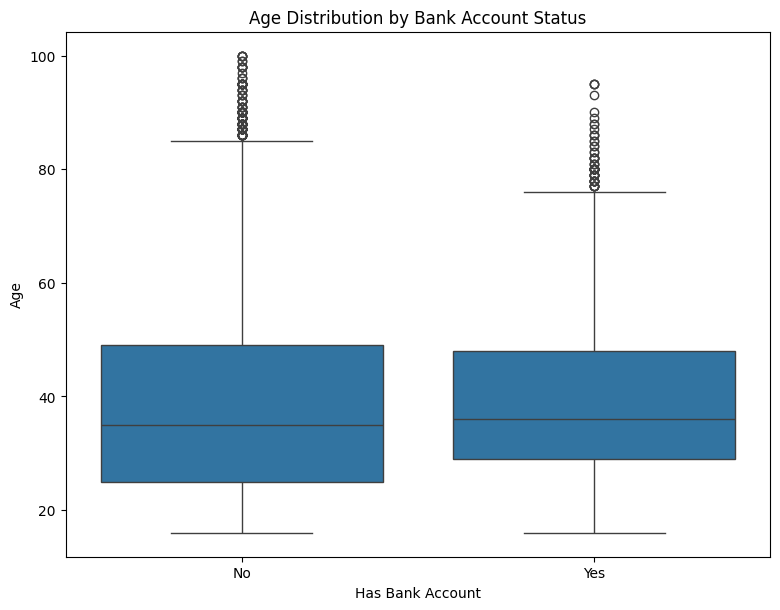

In [18]:
# Visualizations Age Distribution vs Bank Accounts

plt.figure(figsize=(20, 15))

# 1. Age Distribution by Bank Account Status
plt.subplot(2, 2, 1)
sns.boxplot(x='bank_account', y='age_of_respondent', data=train)
plt.title('Age Distribution by Bank Account Status')
plt.xlabel('Has Bank Account')
plt.ylabel('Age')
plt.xticks([0, 1], ['No', 'Yes']);

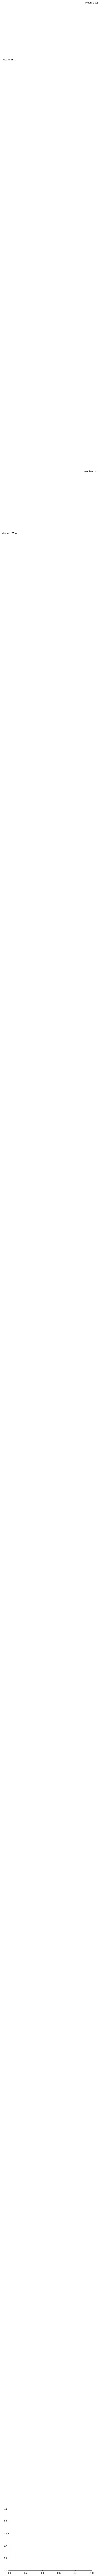

In [19]:
# Add mean and median annotations
means = train.groupby('bank_account')['age_of_respondent'].mean()
medians = train.groupby('bank_account')['age_of_respondent'].median()
for i, (mean, median) in enumerate(zip(means, medians)):
    plt.text(i, mean+2, f'Mean: {mean:.1f}', ha='center')
    plt.text(i, median-2, f'Median: {median:.1f}', ha='center')

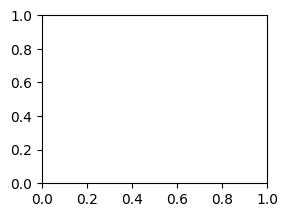

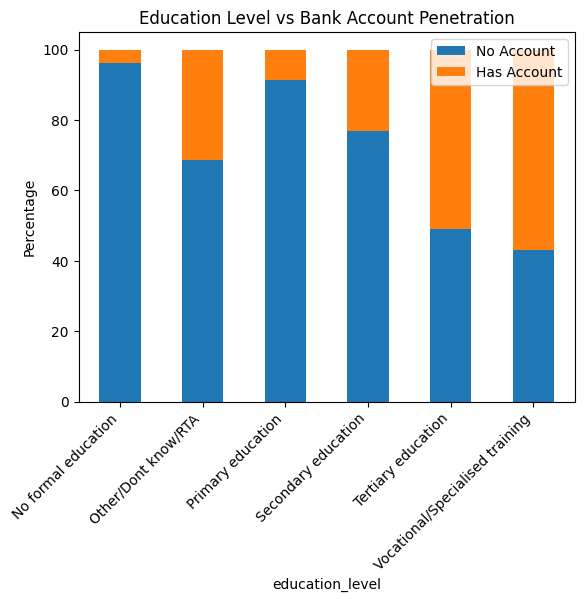

In [20]:
# Visualize Education Level vs Bank Account (Stacked Bar)
plt.subplot(2, 2, 2)
edu_counts = train.groupby(['education_level', 'bank_account']).size().unstack()
(edu_counts.div(edu_counts.sum(axis=1), axis=0)*100).plot(kind='bar', stacked=True)
plt.title('Education Level vs Bank Account Penetration')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(['No Account', 'Has Account']);

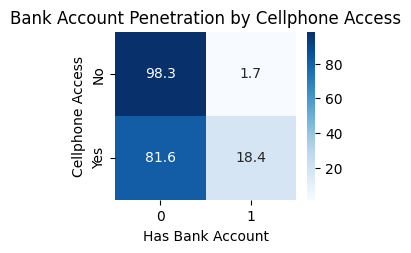

In [21]:
# 3. Cellphone Access Impact
plt.subplot(2, 2, 3)
ct = pd.crosstab(train['cellphone_access'], train['bank_account'], normalize='index')*100
sns.heatmap(ct, annot=True, fmt='.1f', cmap='Blues')
plt.title('Bank Account Penetration by Cellphone Access')
plt.ylabel('Cellphone Access')
plt.xlabel('Has Bank Account');

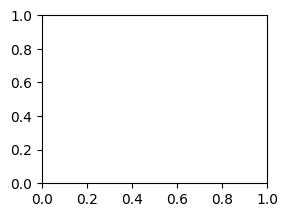

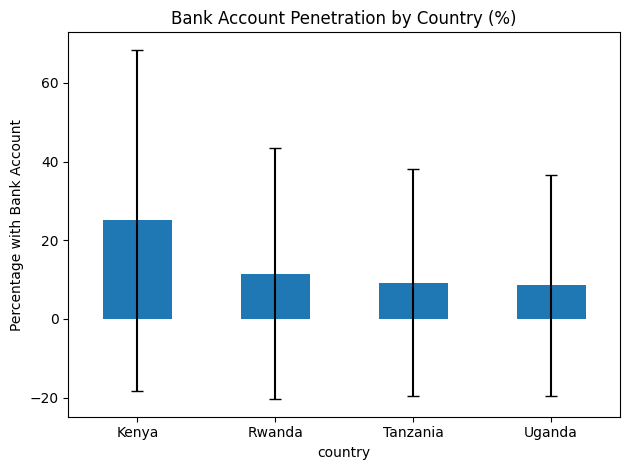

In [22]:
#  Country-wise Comparison
plt.subplot(2, 2, 4)
country_stats = train.groupby('country')['bank_account'].agg(['mean', 'std', 'count'])
country_stats['mean'] = country_stats['mean']*100
country_stats['std'] = country_stats['std']*100
country_stats.plot(kind='bar', y='mean', yerr='std', capsize=4, legend=False)
plt.title('Bank Account Penetration by Country (%)')
plt.ylabel('Percentage with Bank Account')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [23]:
#  Correlation Analysis

# Calculate point-biserial correlation (between numeric and binary)
correlations = {}
for feature in num_features:
    corr, pval = stats.pointbiserialr(train['bank_account'], train[feature])
    correlations[feature] = {'correlation': corr, 'p-value': pval}

print("\n=== Correlation with Bank Account ===")
corr_df = pd.DataFrame(correlations).T
print(corr_df)


=== Correlation with Bank Account ===
                   correlation   p-value
household_size       -0.028326  0.000014
age_of_respondent     0.019429  0.002882


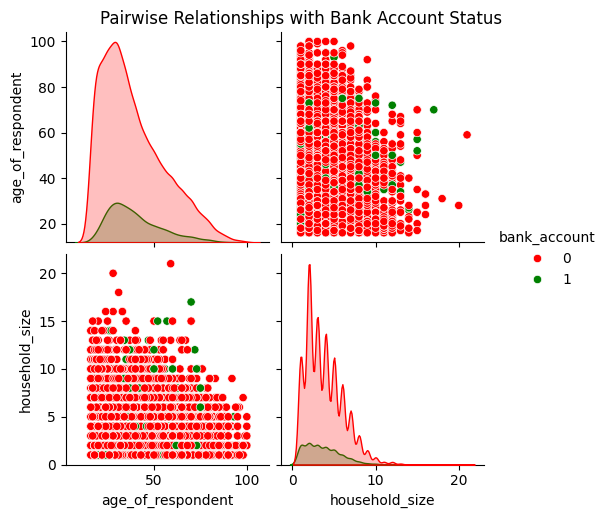

In [24]:
#  Advanced Visualization: Pairplot with Hue

# Select a subset of features for pairplot
plot_features = ['age_of_respondent', 'household_size', 'education_level', 'bank_account']
sns.pairplot(train[plot_features], hue='bank_account',
             diag_kind='kde', palette={0: 'red', 1: 'green'})
plt.suptitle('Pairwise Relationships with Bank Account Status', y=1.02)
plt.show()

In [28]:
#  Feature Engineering

# Create new features
train['age_group'] = pd.cut(train['age_of_respondent'],
                           bins=[0, 18, 25, 35, 45, 55, 65, 100],
                           labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+'])

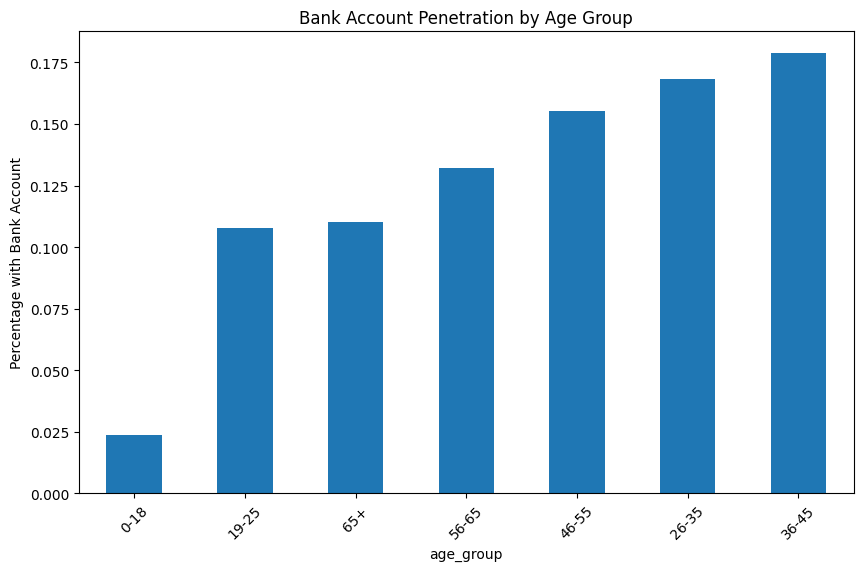

In [29]:
# Visualize age groups
plt.figure(figsize=(10, 6))
age_group_stats = train.groupby('age_group')['bank_account'].mean().sort_values()
age_group_stats.plot(kind='bar')
plt.title('Bank Account Penetration by Age Group')
plt.ylabel('Percentage with Bank Account')
plt.xticks(rotation=45)
plt.show()

In [31]:
#  Model Preparation

# Separate features and target
X = train.drop('bank_account', axis=1)
y = train['bank_account']

# Identify categorical features
# Instead of using np.where, select columns with 'category' dtype
categorical_features_indices = [X.columns.get_loc(col) for col in X.select_dtypes(include=['category']).columns]

# Split data
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, train_size=0.75, stratify=y, random_state=42)

In [32]:
# Model Training with feature Importance Visualization.

#  First ensure all categorical features are properly identified
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

#  Convert ID columns to strings explicitly
id_columns = ['uniqueid']  # Add any other ID columns here
for col in id_columns:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str)
        X_validation[col] = X_validation[col].astype(str)
        categorical_features.append(col)

#  Get categorical feature indices
categorical_features_indices = [i for i, col in enumerate(X_train.columns)
                              if col in categorical_features]

#  Verify before training
print("Categorical features:", categorical_features)
print("Categorical indices:", categorical_features_indices)

#  Train model with verified categorical features
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    logging_level='Verbose'
)

model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation)
)

Categorical features: ['country', 'uniqueid', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type', 'age_group', 'education_simplified', 'household_size_category', 'uniqueid']
Categorical indices: [0, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14]
0:	test: 0.8094399	best: 0.8094399 (0)	total: 169ms	remaining: 1m 24s
1:	test: 0.8143994	best: 0.8143994 (1)	total: 256ms	remaining: 1m 3s
2:	test: 0.8434722	best: 0.8434722 (2)	total: 361ms	remaining: 59.8s
3:	test: 0.8429054	best: 0.8434722 (2)	total: 452ms	remaining: 56s
4:	test: 0.8460202	best: 0.8460202 (4)	total: 526ms	remaining: 52.1s
5:	test: 0.8463516	best: 0.8463516 (5)	total: 617ms	remaining: 50.8s
6:	test: 0.8513126	best: 0.8513126 (6)	total: 705ms	remaining: 49.7s
7:	test: 0.8535739	best: 0.8535739 (7)	total: 808ms	remaining: 49.7s
8:	test: 0.8528578	best: 0.8535739 (7)	total: 897ms	remaining: 49s
9:	test: 0.8533597	best: 0.8535739 (7)	total: 997ms	remaining

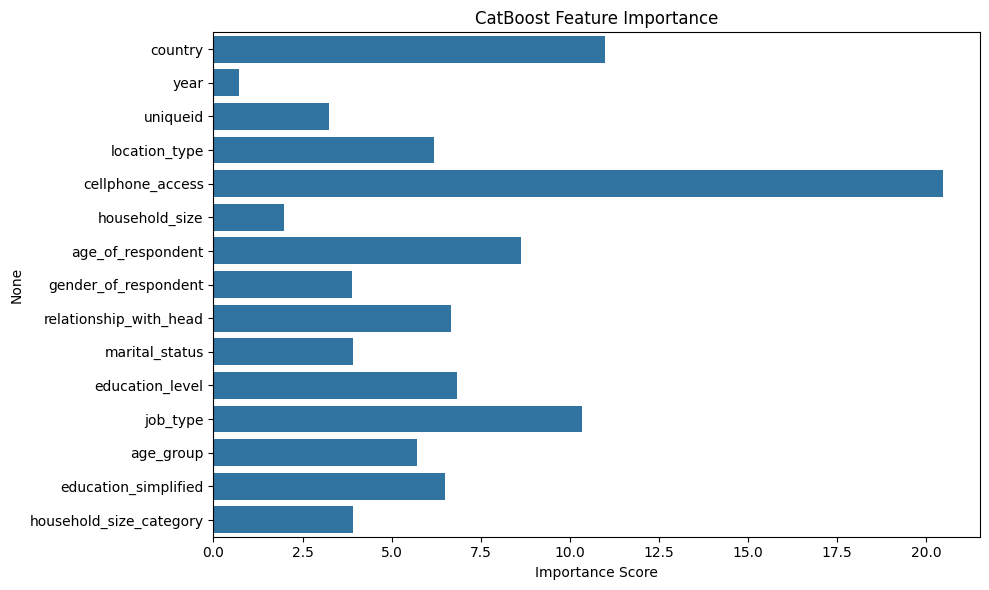

In [33]:
# Feature importance visualization
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [34]:
# Advanced Model Evaluation

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_validation)[:, 1]

# Create a DataFrame with actual and predicted values
results = pd.DataFrame({
    'Actual': y_validation,
    'Predicted_Proba': y_pred_proba
})

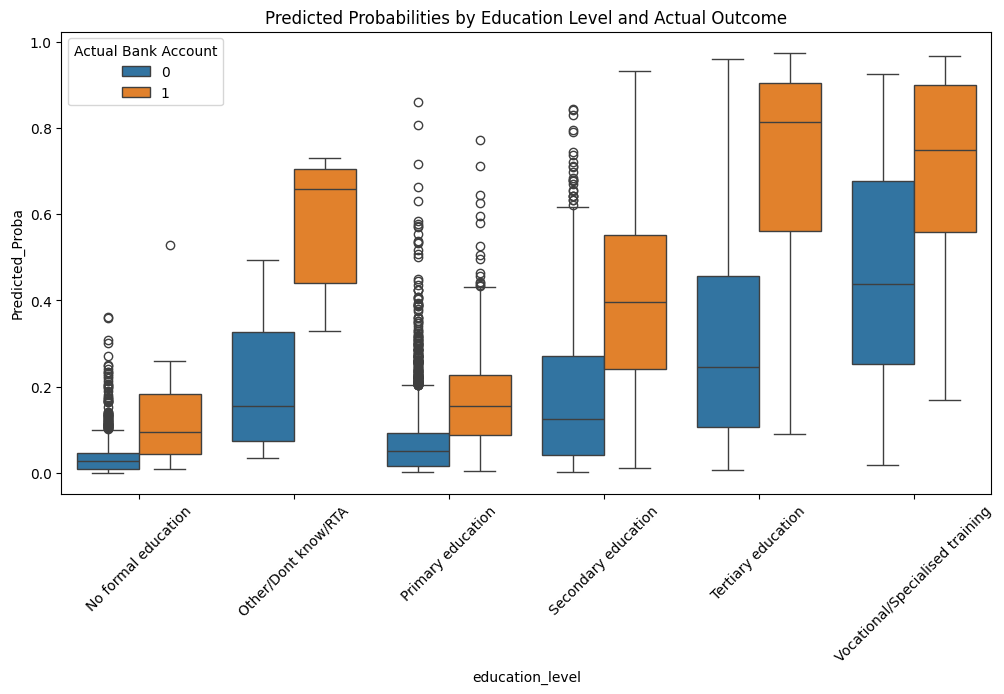

In [35]:
# Add original features for analysis
for feature in ['age_of_respondent', 'education_level', 'country', 'cellphone_access']:
    results[feature] = X_validation[feature].values

# Analyze where model performs well/poorly
plt.figure(figsize=(12, 6))
sns.boxplot(x='education_level', y='Predicted_Proba', hue='Actual', data=results)
plt.title('Predicted Probabilities by Education Level and Actual Outcome')
plt.xticks(rotation=45)
plt.legend(title='Actual Bank Account')
plt.show()

In [36]:
cv_params = model.get_params()
print(cv_params)

{'iterations': 500, 'learning_rate': 0.05, 'depth': 6, 'random_seed': 42, 'logging_level': 'Verbose', 'eval_metric': 'AUC'}


In [61]:

cv_params = {
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'Logloss',  # Use string or metrics.Logloss object
    'eval_metric': 'AUC',
    'random_seed': 42,
    'logging_level': 'Silent'
}

pool = Pool(
    X,
    y,
    cat_features=categorical_features_indices,
    feature_names=list(X.columns)
)


In [65]:
def catboost_cv(pool, params, nfold=5, **kwargs):
    return cv(params=params, pool=pool, fold_count=nfold, **kwargs)

cv_data = catboost_cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    nfold=5,
    iterations=1200,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
cv_data.head()

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.754975,0.021026,0.648191,0.001195,0.648495,0.000658
1,1,0.791705,0.013288,0.607489,0.001399,0.607923,0.001281
2,2,0.808698,0.008862,0.570962,0.004537,0.571667,0.004498
3,3,0.816874,0.004663,0.539560,0.004473,0.540434,0.004344
4,4,0.820310,0.005978,0.513075,0.003808,0.513753,0.003605


In [67]:
print('Best validation AUC score is: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-AUC-mean']),
    cv_data['test-AUC-std'][np.argmax(cv_data['test-AUC-mean'])],
    np.argmax(cv_data['test-AUC-mean'])
))

Best validation AUC score is: 0.87±0.01 on step 258


In [68]:
print('Precise  AUC score: {}'.format(np.max(cv_data['test-AUC-mean'])))

Precise  AUC score: 0.866169254620614


In [77]:
# Don't drop 'uniqueid' from X_test if it exists in X_train
X_test = test.copy()  # Start with original test data

# Make sure X_test has same columns as X_train (in same order)
X_test = X_test[X_train.columns]
predictions_probs = model.predict_proba(X_test)[:, 1]
# Now proceed with prediction
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features_indices = [i for i, col in enumerate(X_test.columns)
                              if col in categorical_features]

predictions = model.predict_proba(X_test)[:, 1]

In [78]:
print(predictions[:10])
print(predictions_probs[:10])

[0.86494915 0.86836683 0.01933688 0.02640495 0.01787805 0.13145362
 0.07792114 0.58691796 0.03781479 0.3851089 ]
[0.86494915 0.86836683 0.01933688 0.02640495 0.01787805 0.13145362
 0.07792114 0.58691796 0.03781479 0.3851089 ]


In [79]:
testId = test['uniqueid']
testCountry = test['country']

In [81]:
submission = pd.DataFrame(data={
    'uniqueid': testId.astype(str) + ' x ' + testCountry.astype(str),
    'bank_account': predictions  # Use your predictions variable here
})

In [82]:
# Generate predictions if not already done
predictions_probs = model.predict_proba(X_test)[:, 1]

# Then create submission
submission = pd.DataFrame(data={
    'uniqueid': testId.astype(str) + ' x ' + testCountry.astype(str),
    'bank_account': predictions_probs
})

In [83]:
# 1. Ensure testId and testCountry are strings
testId = testId.astype(str)
testCountry = testCountry.astype(str)

# 2. Create uniqueid column by concatenation
uniqueid = testId + ' x ' + testCountry

# 3. Create submission DataFrame
submission = pd.DataFrame({
    'uniqueid': uniqueid,
    'bank_account': predictions  # Or predictions_probs if you prefer
})

# 4. Save to CSV
submission.to_csv('Submission.csv', index=False)

In [84]:
# Check if file exists
if os.path.exists('Submission.csv'):
    print("File exists at:", os.path.abspath('Submission.csv'))
else:
    print("File was not created")

File exists at: /content/Submission.csv


In [85]:
import pandas as pd

# Read the submission file
df = pd.read_csv('Submission.csv')

# Convert probabilities to binary predictions (0 or 1)
df['bank_account'] = (df['bank_account'] >= 0.5).astype(int)

# Ensure IDs are in the correct format (if needed)
# df['uniqueid'] = df['uniqueid'].str.replace('uniqueid_', 'uniqueid').str.replace(' x Kenya', '')

# Save the corrected file
df.to_csv('Corrected_Submission.csv', index=False)